<a href="https://colab.research.google.com/github/kotech1/computervision/blob/master/11_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `11-gan.ipynb`

**모델 및 소스코드 참고**  

David Foster저 Generative Deep Learning (O'REILLY출판, 2019)


# Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import os

SAVE_FOLDER = 'data'

if not os.path.exists(SAVE_FOLDER):
    os.mkdir(SAVE_FOLDER)
    os.mkdir(os.path.join(SAVE_FOLDER, 'weights'))

In [3]:

MODE =  'build' #'load' #
#MODE =  'load'

**Encoder 모델 정의**

In [4]:
z_dim = 2

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(z_dim, name='encoder_output')(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

In [5]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

In [6]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0   

In [7]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

@tf.function
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0
EPOCHS = 200

In [9]:
save_folder = os.path.join(SAVE_FOLDER, 'weights')

ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), loss=r_loss)

if MODE == 'build':
    x = np.random.rand(1,28,28,1)
    ae.predict(x)
    ae.save(save_folder)
else:
    ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    #ae.load_weights(save_folder+'/'+'checkpoint')

INFO:tensorflow:Assets written to: data/weights/assets


**학습하기**

In [10]:
# mnist 데이터 읽어오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train/255.
x_test = x_test/255.

# 매 epoch마다 모델 weights 저장
#lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)

#callbacks_list = [checkpoint]
callbacks_list = []
ae.fit(x_train[:1000], x_train[:1000], epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)
ae.save(save_folder)

Epoch 1/200
32/32 [==============================] - 0s 6ms/step - loss: 0.1795
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0755
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0645
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0590
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0570
Epoch 6/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 8/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0541
Epoch 9/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 10/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 11/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 12/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 13/200
32/32 [=================

**모델 읽어들이기**

In [11]:

save_folder = os.path.join(SAVE_FOLDER, 'weights')
#AE = AutoEncoder(encoder, decoder)
#AE.load_weights(save_folder+'/'+'checkpoint')
AE = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})


**생성해 보기**

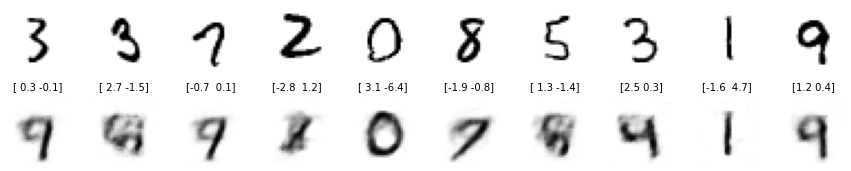

In [17]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = ae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


**Latent space의 분포**

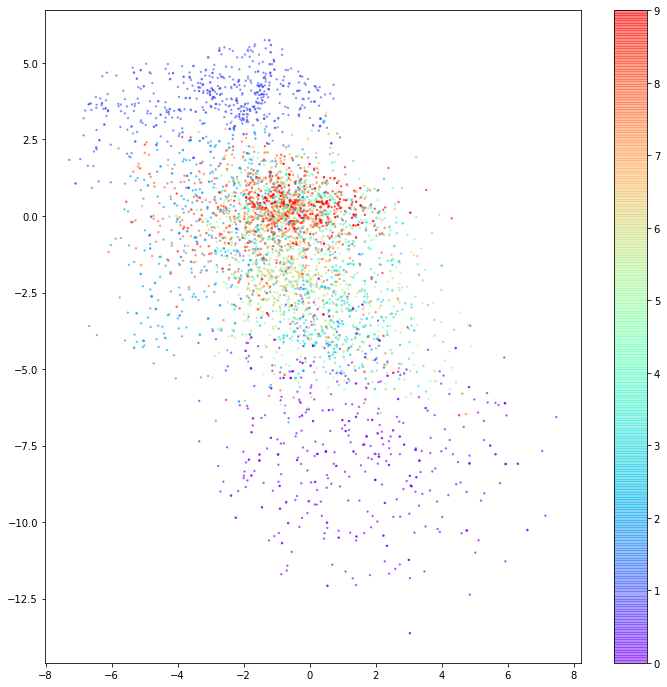

In [18]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

**Latent space에서 일정 간격으로 latent vector를 추출하여 생성된 결과**

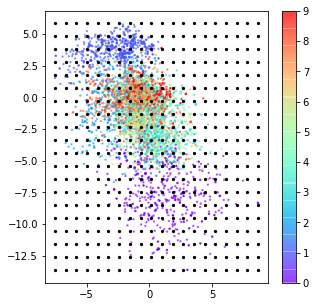

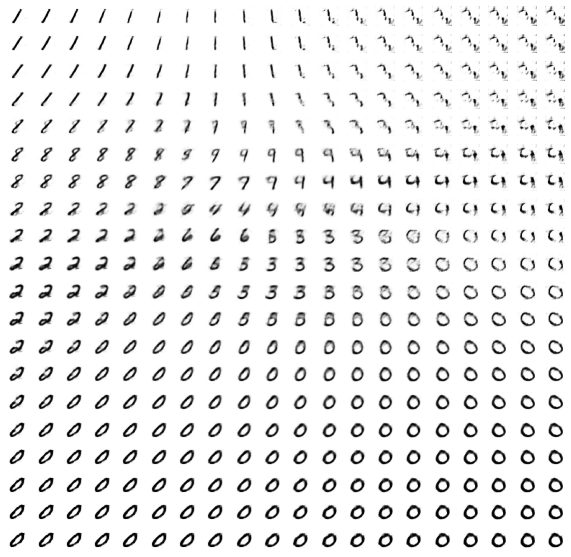

In [19]:
n_to_show = 5000
grid_size = 20
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

# GAN

In [21]:
!mkdir -p gan_data/motorbike
!mkdir -p gan_data/images
!mkdir -p gan_data/weights
!gdown --id 1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa -O gan_data/motorbike/full_numpy_bitmap_motorbike.npy


Downloading...
From: https://drive.google.com/uc?id=1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa
To: /content/gan_data/motorbike/full_numpy_bitmap_motorbike.npy
133MB [00:00, 236MB/s]


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, ReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
import os
from os import walk
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

**Quick! Draw! database**  
Dataset 홈페이지:  https://quickdraw.withgoogle.com/data  
Motorbike numpy 다운로드: https://console.cloud.google.com/storage/browser/_details/quickdraw_dataset/full/numpy_bitmap/motorbike.npy  

Quick & Draw 참여 페이지  
https://quickdraw.withgoogle.com/  


In [23]:
SAVE_FOLDER = 'gan_data'

def load_quickdraw(folder):

    mypath = os.path.join(SAVE_FOLDER, folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0

        x = x.reshape(x.shape[0], 28, 28, 1)

        y = [i] * len(x)
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0:
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1

    return xtotal, ytotal

In [24]:
x_train, y_train = load_quickdraw('motorbike')

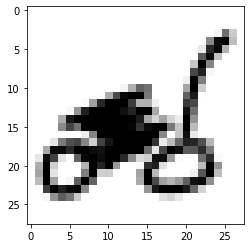

In [30]:
plt.imshow(x_train[501,:,:,0], cmap = 'binary')
plt.show()

입력 이미지 사이즈: (28,28)

In [32]:
input_dim = (28,28,1)
weight_init = RandomNormal(mean=0., stddev=0.02)

**Discriminator 모델 정의**

In [33]:
discriminator_input = keras.Input(shape=input_dim, name='discriminator_input')
x = Conv2D(64, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_0')(discriminator_input)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(64, 5, strides=2, padding="same",
    kernel_initializer=weight_init, name='discriminator_conv_1')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_2')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=1, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_3')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid',
    kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)
discriminator = keras.Model(discriminator_input, discriminator_output, name = 'discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 14, 14, 64)        1664      
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 7, 7, 64)          102464    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)        

**Generator 모델 정의**

In [34]:
z_dim = 100

generator_input = keras.Input(shape=(z_dim,), name='generator_input')
x = Dense(np.prod((7, 7, 64)), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(generator_input)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Reshape((7,7,64))(x)
x = UpSampling2D()(x)
x = Conv2D(128, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_0')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_1')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(64, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_2')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(1, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_3')(x)
generator_output = Activation('tanh')(x)
generator = keras.Model(generator_input, generator_output, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
re_lu_4 (ReLU)               (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 14, 14, 128)       20

Discriminator를 먼저 컴파일

In [35]:
### COMPILE DISCRIMINATOR

discriminator.compile(
  optimizer=RMSprop(lr=0.0008),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

Discriminator를 freeze하고, generator와 연결하여  
model을 정의  
Generator용 모델 컴파일  

In [36]:
### COMPILE THE FULL GAN

def set_trainable(m, val):
    m.trainable = val
    for l in m.layers:
        l.trainable = val

# 먼저discriminator를 훈련 불가능 상태로 만듬.
set_trainable(discriminator, False)

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))
model = Model(model_input, model_output)

model.compile(optimizer=RMSprop(lr=0.0004) , loss='binary_crossentropy', metrics=['accuracy']
  , experimental_run_tf_function=False
)

# compile이 완료되었으므로, discriminator를 훈련 가능 상태로 복귀.
set_trainable(discriminator, True)

최초 실행시에는 `build`를 사용  
저장된 weights를 loading해서 계속할 때에는 `load`사용

In [37]:
mode = 'build'
#mode = 'load'

if mode == 'build':
    model.save(SAVE_FOLDER)
else:
    model.load_weights(os.path.join(SAVE_FOLDER, 'weights/weights.h5'))

INFO:tensorflow:Assets written to: gan_data/assets


d,g의 loss 및 accuracy를 저장해 두는 변수

In [38]:
total_epoch = 0
d_losses = []
g_losses = []

**GAN 학습**

In [39]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return model.train_on_batch(noise, valid)



# 중간 epoch에서 생성 이미지를 샘플링하여 저장해두기 위한 함수
def sample_images(run_folder):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig, axs = plt.subplots(r, c, figsize=(15,15))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % total_epoch))
    plt.close()

# discriminator와 generator를 번갈아가며, 학습
def train(x_train, batch_size, epochs, run_folder,
          print_every_n_batches = 50,
          ):

    global total_epoch
    for epoch in range(total_epoch, total_epoch + epochs):

        d = train_discriminator(x_train, batch_size)
        g = train_generator(batch_size)

        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

        d_losses.append(d)
        g_losses.append(g)

        if epoch % print_every_n_batches == 0:
            sample_images(run_folder)
            #model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
            model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
            model.save(run_folder)

        total_epoch += 1


In [40]:
BATCH_SIZE = 64
EPOCHS = 2000
PRINT_EVERY_N_BATCHES = 20

train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = SAVE_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
)

0 [D loss: (0.727)(R 0.690, F 0.765)] [D acc: (0.328)(0.656, 0.000)] [G loss: 0.683] [G acc: 1.000]
INFO:tensorflow:Assets written to: gan_data/assets
1 [D loss: (0.683)(R 0.639, F 0.727)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.682] [G acc: 1.000]
2 [D loss: (0.466)(R 0.213, F 0.720)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.058] [G acc: 1.000]
3 [D loss: (9.896)(R 0.000, F 19.792)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.533] [G acc: 1.000]
4 [D loss: (0.863)(R 0.389, F 1.337)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.520] [G acc: 1.000]
5 [D loss: (0.637)(R 0.433, F 0.840)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.491] [G acc: 1.000]
6 [D loss: (0.613)(R 0.420, F 0.806)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.460] [G acc: 1.000]
7 [D loss: (0.636)(R 0.384, F 0.888)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.443] [G acc: 1.000]
8 [D loss: (0.671)(R 0.382, F 0.960)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.429] [G acc: 1.000]
9 [D loss: (0.785)(R 0.397, F 1.173)] [D acc: (0

**학습 epoch에 따른 d,g의 loss및 accuracy 변화 그래프**

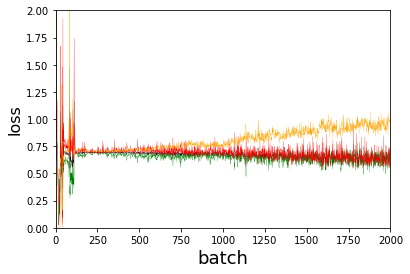

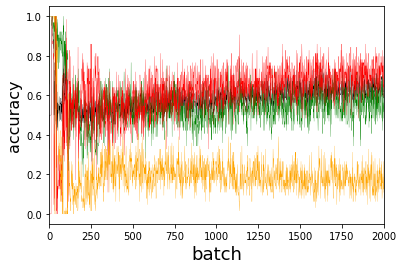

In [41]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

최종 학습된 결과를 random gaussian noise를 이용하여 생성

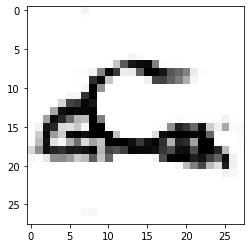

In [55]:
import numpy as np
#z_dim = 100

noise = np.random.normal(0, 1, (1, z_dim))
img = generator.predict(noise)
plt.imshow(img[0].squeeze(), cmap='binary')
plt.show()

epoch 20 생성 샘플

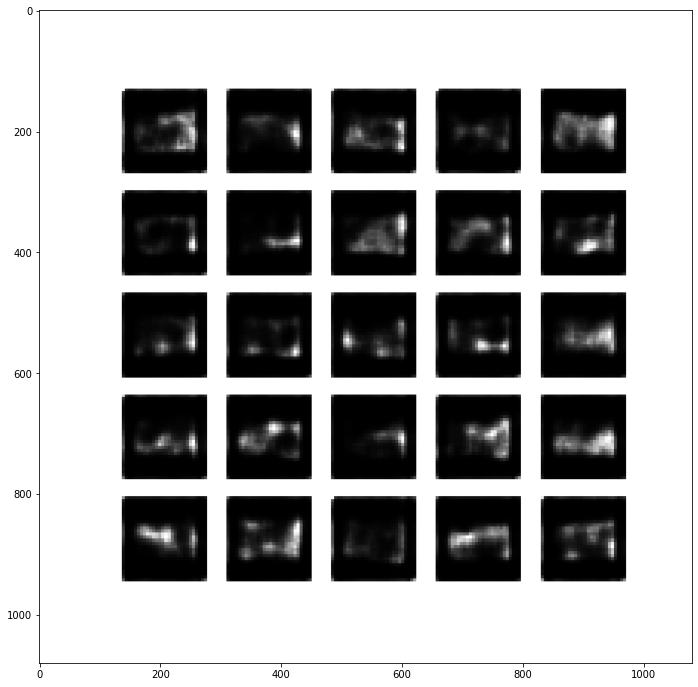

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

image = mp_image.imread('gan_data/images/sample_%d.png' % 20)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 100 생성 샘플

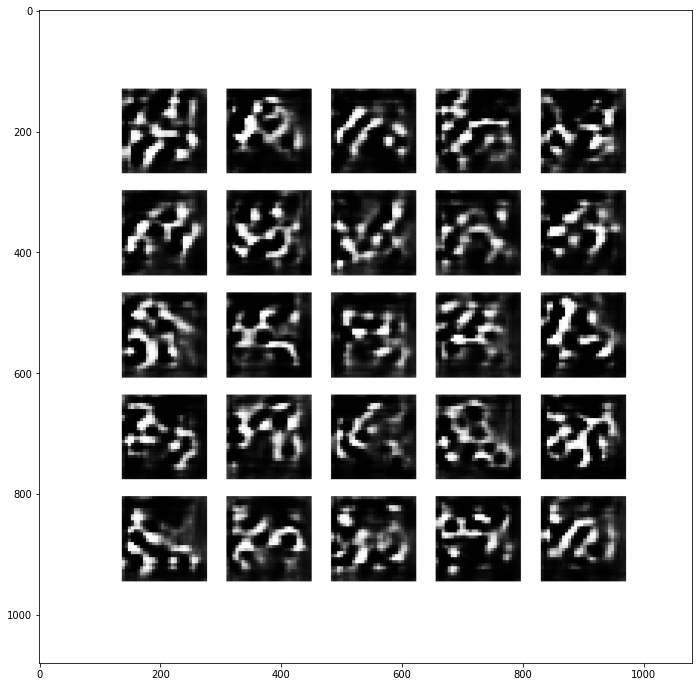

In [57]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 100)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 200 생성 샘플

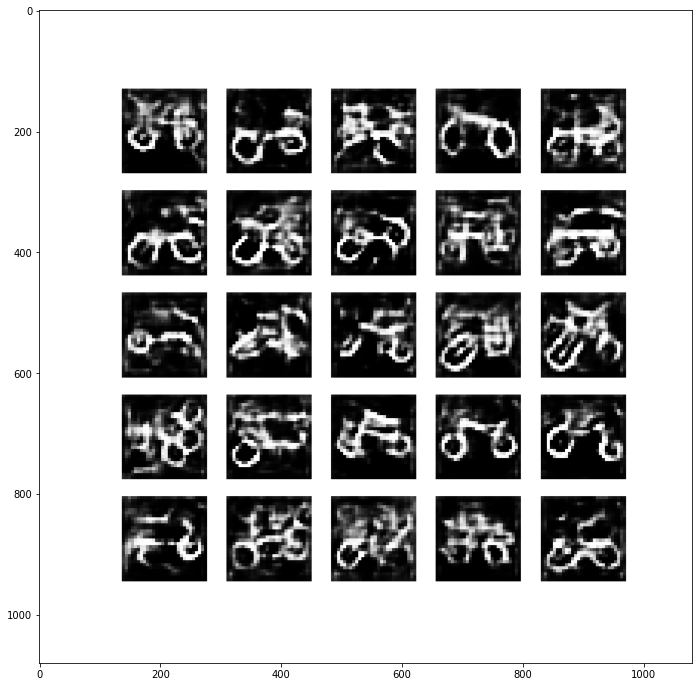

In [49]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 200)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()